In [2]:
import os
import dynamics
from packaging import version
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import glob
import numpy as np
import matplotlib.pyplot as plt
import hypernetx
from models import HigherOrderModel
import torch
from utils import return_single_result, bar_plot


2023-09-21 20:52:58.329662: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 20:52:58.389141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 20:52:59.073359: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Figure 3 (a): Point-based dataset with point-based MAE

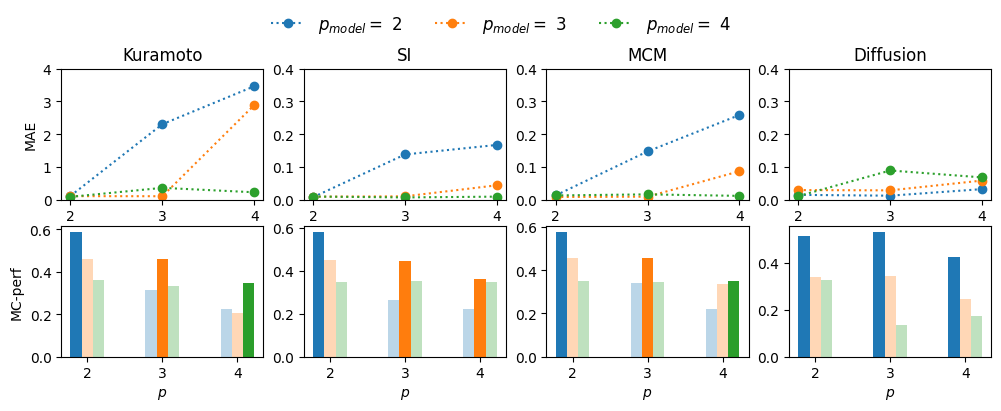

In [7]:
dataset_name = 'ERHypergraphXGI'
order = 4
dataset_network_size = 20
dataset_sample_size = 500
num_folds = 10
non_linear = True
alphas = {
    'Kuramoto': [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'SI': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    "MCMI": [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'Diffusion': [([1., 1., 1.]), ([.3, .3, .3]), ([.3, .3, .3])]
}
initialisations = {
    'Kuramoto': "-pipiuniform",
    'SI': "01uniform",
    "MCMI": "skewed",
    'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
     'SI': dynamics.SILiftingFunction,
    "MCMI": dynamics.MCMILiftingFunction,
    'Diffusion': dynamics.DiffusionLiftingFunction
}

agg='min'

fig,axs=plt.subplots(2,4,figsize=[12,4])
axs[0, 0].set_ylabel("MAE")
axs[1, 0].set_ylabel("MC-perf")
axs[0, 0].set_title("Kuramoto")
axs[0, 0].set_ylim(0, 4)
axs[0, 1].set_title("SI")
axs[0, 1].set_ylim(0, 0.4)
axs[0, 2].set_title("MCM")
axs[0, 2].set_ylim(0, 0.4)
axs[0, 3].set_title("Diffusion")
axs[0, 3].set_ylim(0, 0.4)
for i, name in enumerate(functions):
    result = np.zeros((3, 3))
    scaled_result = []
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        for column, nonlinear_cut_data in enumerate([2, 3, 4]):
            lifting_func = functions[name](
                order, nonlinear_cut_data)
            data_dir = 'our_results/cross_validation/'+dataset_name+'/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() + "_" + initialisations[name]
            result[row, column] = return_single_result(
                non_linear, nonlinear_cut_model, agg, data_dir, num_folds)
        axs[0][i].plot(result[row, :], label=r'$p_{model}=$ '+str(nonlinear_cut_model),
                           marker="o", linestyle="dotted")
    result = result / np.max(result)
    diff_min = np.zeros((3, 3))
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        diff_min[row, :] = np.exp(-result[row, :])*np.exp(-(nonlinear_cut_model)/(4))
        max_values = np.amax(diff_min, axis=0)
        normalised_results = diff_min
    bar_plot(axs[1][i], normalised_results, name,alphas[name])
    axs[0][i].set_xticks([0, 1, 2], ['2', '3', '4'])
handles, labels = axs[0][i].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='upper center', ncol=5,fontsize=12)
plt.subplots_adjust(top=0.83)
os.makedirs("plots/derivatives",exist_ok=True)
plt.savefig("plots/derivatives/derivatives_joint_XGI.pdf",
            bbox_inches='tight')

## Figure 3 (c): Trajectory-based dataset with trajectory MAE

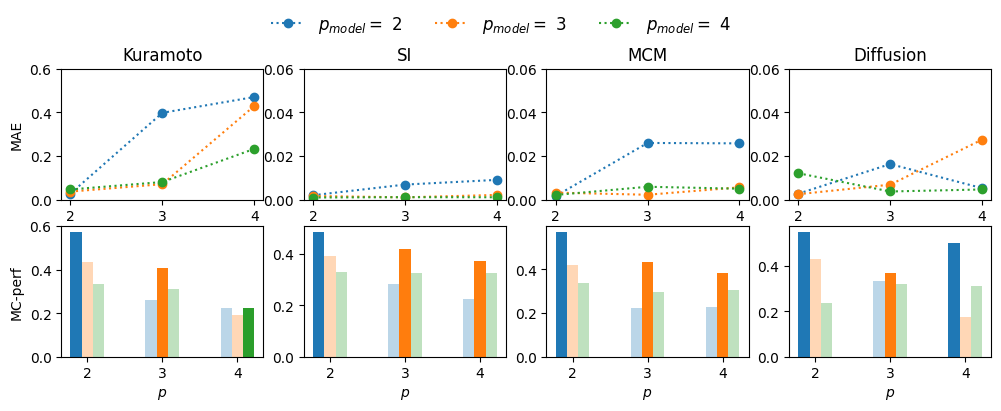

In [8]:
dataset_name = 'ERHypergraphXGI'
order = 4
dataset_network_size = 20
dataset_sample_size = 25
num_folds = 10
non_linear = True
alphas = {
    'Kuramoto': [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'SI': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    "MCMI": [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    'Diffusion': [([1., .3, 1.]), ([.3, 1., .3]), ([.3, .3, .3])]
}
initialisations = {
    'Kuramoto': "-pipiuniform",
    'SI': "01uniform",
    "MCMI": "skewed",
    'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
    'SI': dynamics.SILiftingFunction,
    "MCMI": dynamics.MCMILiftingFunction,
    'Diffusion': dynamics.DiffusionLiftingFunction
}

agg='min'

fig,axs=plt.subplots(2,4,figsize=[12,4])
axs[0, 0].set_ylabel("MAE")
axs[1, 0].set_ylabel("MC-perf")
axs[0, 0].set_title("Kuramoto")
axs[0, 0].set_ylim(0, 0.6)
axs[0, 1].set_title("SI")
axs[0, 1].set_ylim(0, 0.06)
axs[0, 2].set_title("MCM")
axs[0, 2].set_ylim(0, 0.06)
axs[0, 3].set_title("Diffusion")
axs[0, 3].set_ylim(0, 0.06)
for i, name in enumerate(functions):
    result_old = np.zeros((3, 3))
    scaled_result = []
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        for column, nonlinear_cut_data in enumerate([2, 3, 4]):
            lifting_func = functions[name](
                order, nonlinear_cut_data)
            data_dir = 'our_results/cross_validation/'+dataset_name+'/trajectories/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() + "_" + initialisations[name]
            path = data_dir + "/"+"model_non_linear"+str(non_linear) + '_'+str(nonlinear_cut_model)+'_fold'+str(1)
            num_samples=100
            time_steps=100
            test_network_size=20
            MSE=False
    result_old = np.load(path+'/mean_traj_error_'+str(num_samples)+"_" + str(time_steps)+"_"+str(test_network_size)+".npy")
    result = result_old / np.max(result_old)
    diff_min = np.zeros((3, 3))
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        axs[0][i].plot(result_old[row, :], label=r'$p_{model}=$ '+str(nonlinear_cut_model),
                           marker="o", linestyle="dotted")
        diff_min[row, :] = np.exp(-result[row, :])*np.exp(-(nonlinear_cut_model)/(4))
        max_values = np.amax(diff_min, axis=0)

        normalised_results = diff_min
    bar_plot(axs[1][i], normalised_results, name,alphas[name])
    axs[0][i].set_xticks([0, 1, 2], ['2', '3', '4'])
handles, labels = axs[0][i].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='upper center', ncol=5,fontsize=12)
plt.subplots_adjust(top=0.83)
plt.savefig("./plots/derivatives/trajectories_joint_mean_XGI.pdf",
            bbox_inches='tight')

## Figure 4: Real-world datasets

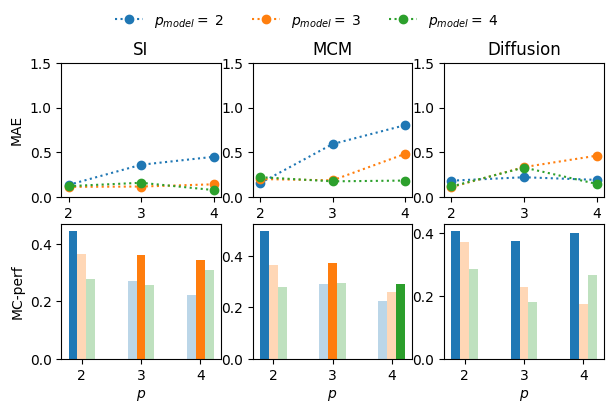

In [9]:
dataset_name = 'SocioPatterns_highschool'
order = 4
dataset_network_size = 20
dataset_sample_size = 50
num_folds = 10
non_linear = True
alphas = {
#    'Kuramoto': [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'SI': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    "MCMI": [([1., .3, .3]), ([.3, 1., .3]), ([.3, .3, 1.])],
    'Diffusion': [([1., 1., 1.]), ([.3, .3, .3]), ([.3, .3, .3])]
}
dataset_names={
 #   'Kuramoto': "Brain",
    'SI': "SocioPatterns_highschool",
    "MCMI": "SocioPatterns_highschool",
    'Diffusion': "SocioPatterns_highschool"
}
dataset_network_sizes = {
    #   'Kuramoto': "Brain",
       'SI': 327,
    "MCMI": 327,
       'Diffusion': 327
}
initialisations = {
  #  'Kuramoto': "-pipiuniform",
    'SI': "01uniform",
    "MCMI": "skewed",
    'Diffusion': "-11uniform"
}
frames = {
    #  'Kuramoto': 0,
     'SI': 0,
    "MCMI": 1,
     'Diffusion': 2
}

functions = {
   #  'Kuramoto': dynamics.KuramotoLiftingFunction,
    'SI': dynamics.SILiftingFunction,
    "MCMI": dynamics.MCMILiftingFunction,
    'Diffusion': dynamics.DiffusionLiftingFunction
}

agg='min'

fig,axs=plt.subplots(2,3,figsize=[7,4])
#fig.supxlabel("model order")
axs[0, 0].set_ylabel("MAE")
axs[1, 0].set_ylabel("MC-perf")
#axs[0, 0].set_title("Kuramoto")
#axs[0, 0].set_ylim(0, 2.5)
axs[0, 0].set_title("SI")
axs[0, 0].set_ylim(0, 1.5)
axs[0, 1].set_title("MCM")
axs[0, 1].set_ylim(0, 1.5)
axs[0, 2].set_title("Diffusion")
axs[0, 2].set_ylim(0, 1.5)
for i, name in zip(frames.values(),functions):
    result=np.zeros((3,3))
    scaled_result = []
    for row,nonlinear_cut_model in enumerate([2,3,4]):
        for column,nonlinear_cut_data in enumerate([2,3,4]):
            lifting_func = functions[name](
            order, nonlinear_cut_data)
            data_dir = 'our_results/cross_validation/'+dataset_names[name]+'/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_sizes[name]) + '_' + str(order) + '_' + lifting_func.name() +"_" + initialisations[name]
            result[row, column] = return_single_result(
                non_linear, nonlinear_cut_model, agg, data_dir, num_folds)
        axs[0][i].plot(result[row,:], label=r'$p_{model}=$ '+str(nonlinear_cut_model),
                       marker="o", linestyle="dotted")
    result = result / np.max(result)
    diff_min = np.zeros((3, 3))
    for row,nonlinear_cut_model in enumerate([2, 3, 4]):
        diff_min[row, :] = np.exp(-result[row, :]) * np.exp(-(nonlinear_cut_model)/(4))
        max_values = np.amax(diff_min, axis=0)
        normalised_results = diff_min
    bar_plot(axs[1][i],normalised_results, name,alphas[name])
    axs[0][i].set_xticks([0, 1, 2], ['2', '3', '4']) 
handles, labels = axs[0][i].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='upper center', ncol=5)
plt.subplots_adjust(top=0.85)
plt.savefig("./plots/derivatives/real_datasets_joint.pdf",
            bbox_inches='tight')


## Supplementary Materials Figure 2: Trajectory-based dataset with point-based MAE

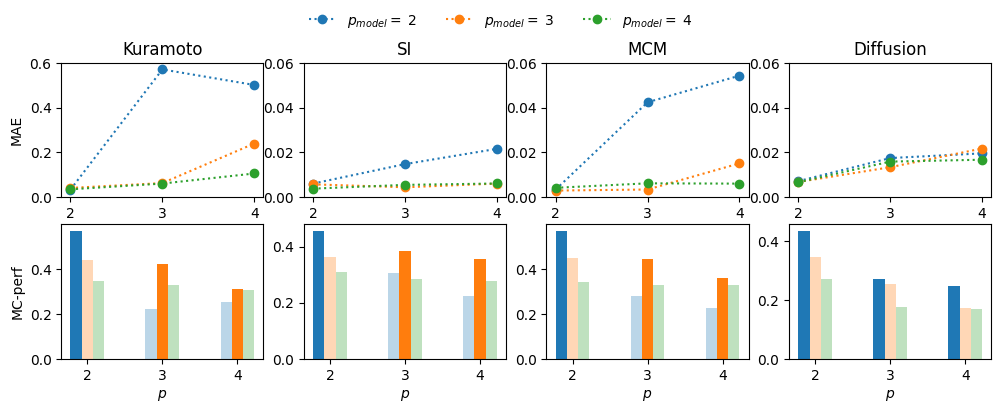

In [10]:
dataset_name = 'ERHypergraphXGI'
order = 4
dataset_network_size = 20
dataset_sample_size = 25
num_folds = 10
non_linear = True
alphas = {
    'Kuramoto': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    'SI': [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    "MCMI": [([1., .3, .3]), ([.3, 1., 1.]), ([.3, .3, .3])],
    'Diffusion': [([1., 1., 1.]), ([.3, .3, .3]), ([.3, .3, .3])]
}
initialisations = {
    'Kuramoto': "-pipiuniform",
    'SI': "01uniform",
    "MCMI": "skewed",
    'Diffusion': "-11uniform"
}

functions = {
     'Kuramoto': dynamics.KuramotoLiftingFunction,
    'SI': dynamics.SILiftingFunction,
    "MCMI": dynamics.MCMILiftingFunction,
    'Diffusion': dynamics.DiffusionLiftingFunction
}

agg='min'

fig,axs=plt.subplots(2,4,figsize=[12,4])
axs[0, 0].set_ylabel("MAE")
axs[1, 0].set_ylabel("MC-perf")
axs[0, 0].set_title("Kuramoto")
axs[0, 0].set_ylim(0, 0.6)
axs[0, 1].set_title("SI")
axs[0, 1].set_ylim(0, 0.06)
axs[0, 2].set_title("MCM")
axs[0, 2].set_ylim(0, 0.06)
axs[0, 3].set_title("Diffusion")
axs[0, 3].set_ylim(0, 0.06)
for i, name in enumerate(functions):
    result = np.zeros((3, 3))
    scaled_result = []
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        for column, nonlinear_cut_data in enumerate([2, 3, 4]):
            lifting_func = functions[name](
                order, nonlinear_cut_data)
            data_dir = 'our_results/cross_validation/'+dataset_name+'/trajectories/data_' + str(dataset_sample_size) + '_' + str(
                dataset_network_size) + '_' + str(order) + '_' + lifting_func.name() + "_" + initialisations[name]
            result[row, column] = return_single_result(
                non_linear, nonlinear_cut_model, agg, data_dir, num_folds)
        axs[0][i].plot(result[row, :], label=r'$p_{model}=$ '+str(nonlinear_cut_model),
                           marker="o", linestyle="dotted")
    result = result / np.max(result)
    diff_min = np.zeros((3, 3))
    for row, nonlinear_cut_model in enumerate([2, 3, 4]):
        diff_min[row, :] = np.exp(-result[row, :])*np.exp(-(nonlinear_cut_model)/(4))
        max_values = np.amax(diff_min, axis=0)
        normalised_results = diff_min
    bar_plot(axs[1][i], normalised_results, name,alphas[name])
    axs[0][i].set_xticks([0, 1, 2], ['2', '3', '4'])
handles, labels = axs[0][i].get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc='upper center', ncol=5)
plt.subplots_adjust(top=0.85)
plt.savefig("./plots/derivatives/trajectories_joint_XGI.pdf",
            bbox_inches='tight')
